sktime supports a number of advanced composition patterns to create forecasters out of simpler components:

 - reduction - building a forecaster from estimators of "simpler" scientific types, like scikit-learn regressors. A common example is feature/label tabulation by rolling window, aka the "direct reduction strategy".
 - tuning - determining values for hyper-parameters of a forecaster in a data-driven manner. A common example is grid search on temporally rolling re-sampling of train/test splits.
 - pipelining - concatenating transformers with a forecaster to obtain one forecaster. A common example is detrending and deseasonalizing then forecasting, an instance of this is the common "STL forecaster".
 - autoML, also known as automated model selection - using automated tuning strategies to select not only hyper-parameters but entire forecasting strategies. A common example is on-line multiplexer tuning.


For illustration, all estimators below will be presented on the basic forecasting workflow - though they also support the advanced forecasting and evaluation workflows under the unified sktime interface (see Section 1).

For use in the other workflows, simply replace the "forecaster specification block" ("forecaster=") by the forecaster specification block in the examples presented below.

In [2]:
# imports necessary for this chapter
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series

# data loading for illustration (see section 1 for explanation)
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)
fh = ForecastingHorizon(y_test.index, is_relative=False)

C:\Users\trana\.conda\envs\sktime_env\lib\site-packages\sktime\datasets\_single_problem_loaders.py:658: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  y = pd.read_csv(path, index_col=0, squeeze=True, dtype={1: float})


3.1 Reduction: from forecasting to regression
3.1 Reduction: from forecasting to regression
sktime provides a meta-estimator that allows the use of any scikit-learn estimator for forecasting.

 - modular and compatible with scikit-learn, so that we can easily apply any scikit-learn regressor to solve our forecasting problem,
 - parametric and tuneable, allowing us to tune hyper-parameters such as the window length or strategy to generate forecasts
 - adaptive, in the sense that it adapts the scikit-learn's estimator interface to that of a forecaster, making sure that we can tune and properly evaluate our model


Example: we will define a tabulation reduction strategy to convert a k-nearest neighbors regressor (sklearn KNeighborsRegressor) into a forecaster. The composite algorithm is an object compliant with the sktime forecaster interface (picture: big robot), and contains the regressor as a parameter accessible component (picture: little robot). In fit, the composite algorithm uses a sliding window strategy to tabulate the data, and fit the regressor to the tabulated data (picture: left half). In predict, the composite algorithm presents the regressor with the last observed window to obtain predictions (picture: right half).

Below, the composite is constructed using the shorthand function make_reduction which produces a sktime estimator of forecaster scitype. It is called with a constructed scikit-learn regressor, regressor, and additional parameter which can be later tuned as hyper-parameters

In [3]:
from sklearn.neighbors import KNeighborsRegressor

from sktime.forecasting.compose import make_reduction

In [44]:
regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")

C:\Users\trana\.conda\envs\sktime_env\lib\site-packages\sktime\forecasting\base\_fh.py:100: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  values = pd.Int64Index(values, dtype=int)
C:\Users\trana\.conda\envs\sktime_env\lib\site-packages\sktime\utils\datetime.py:103: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  assert isinstance(by, (int, np.integer, pd.Int64Index)), type(by)
C:\Users\trana\.conda\envs\sktime_env\lib\site-packages\sktime\utils\datetime.py:40: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return pd.Int64Index([d.n / count for d in duration])
C:\Users\trana\.conda\envs\sktime_env\lib\site-packages\sktime\utils\validation\series.py:274: FutureWarning: 

0.14187443909112035

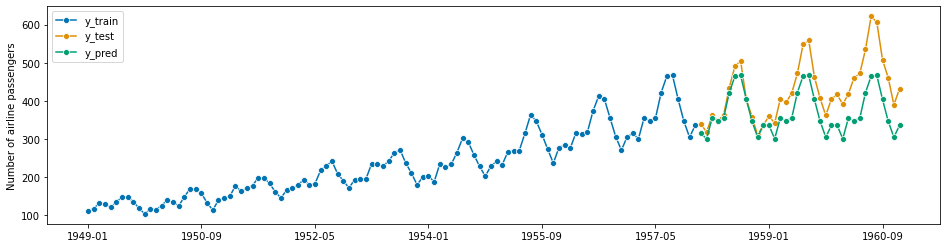

In [45]:
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

In the above example we use the "recursive" reduction strategy. Other implemented strategies are:

 - "direct",
 - "dirrec",
 - "multioutput".
Parameters can be inspected using scikit-learn compatible get_params functionality (and set using set_params). This provides tunable and nested access to parameters of the KNeighborsRegressor (as estimator_etc), and the window_length of the reduction strategy. Note that the strategy is not accessible, as underneath the utility function this is mapped on separate algorithm classes. For tuning over algorithms, see the "autoML" section below.

In [6]:
forecaster.get_params()


{'estimator__algorithm': 'auto',
 'estimator__leaf_size': 30,
 'estimator__metric': 'minkowski',
 'estimator__metric_params': None,
 'estimator__n_jobs': None,
 'estimator__n_neighbors': 1,
 'estimator__p': 2,
 'estimator__weights': 'uniform',
 'estimator': KNeighborsRegressor(n_neighbors=1),
 'window_length': 15}

3.2 Pipelining, detrending and deseasonalization
A common composition motif is pipelining: for example, first deseasonalizing or detrending the data, then forecasting the detrended/deseasonalized series. When forecasting, one needs to add the trend and seasonal component back to the data.

3.2.1 The basic forecasting pipeline
sktime provides a generic pipeline object for this kind of composite modelling, the TransformedTargetForecaster. It chains an arbitrary number of transformations with a forecaster. The transformations should be instances of estimators with series-to-series-transformer scitype. An example of the syntax is below:

In [48]:
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer

C:\Users\trana\.conda\envs\sktime_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\trana\.conda\envs\sktime_env\lib\site-packages\sktime\utils\datetime.py:40: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return pd.Int64Index([d.n / count for d in duration])
C:\Users\trana\.conda\envs\sktime_env\lib\site-packages\sktime\utils\validation\series.py:274: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return type(index) in (pd.Int64Index, pd.RangeIndex)


0.15497687813580535

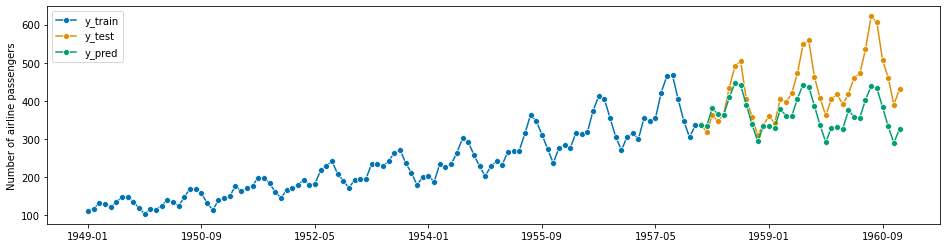

In [49]:
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
        ("forecast", ARIMA()),
    ]
)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

The TransformedTargetForecaster is constructed with a list of steps, each a pair of name and estimator. The last estimator should be of forecaster scitype, the other estimators should be series-to-series transformers which possess both a transform and inverse_transform method. The resulting estimator is of forecaster scitype and has all interface defining methods. In fit, all transformers apply fit_transforms to the data, then the forecaster's fit; in predict, first the forecaster's predict is applied, then the transformers' inverse_transform in reverse order.

3.2.2 The Detrender as pipeline component
For detrending, we can use the Detrender. This is an estimator of series-to-transformer scitype that wraps an arbitrary forecaster. For example, for linear detrending, we can use PolynomialTrendForecaster to fit a linear trend, and then subtract/add it using the Detrender transformer inside TransformedTargetForecaster.

To understand better what happens, we first examine the detrender separately:

In [52]:
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Detrender
import numpy as np

C:\Users\trana\.conda\envs\sktime_env\lib\site-packages\sktime\utils\datetime.py:40: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return pd.Int64Index([d.n / count for d in duration])
C:\Users\trana\.conda\envs\sktime_env\lib\site-packages\sktime\forecasting\base\_fh.py:100: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  values = pd.Int64Index(values, dtype=int)
C:\Users\trana\.conda\envs\sktime_env\lib\site-packages\sktime\utils\datetime.py:40: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return pd.Int64Index([d.n / count for d in duration])
C:\Users\trana\.conda\envs\sktime_env\lib\site-packages\sktime\utils\validation\series.py:274: FutureWarning: pandas.Int64I

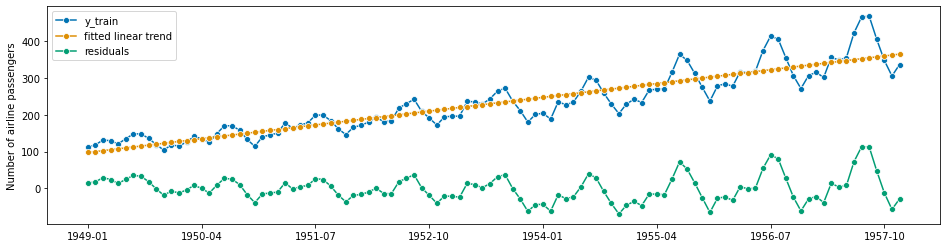

In [56]:
# linear detrending
forecaster = PolynomialTrendForecaster(degree=1)
transformer = Detrender(forecaster=forecaster)
yt = transformer.fit_transform(y_train)

# internally, the Detrender uses the in-sample predictions
# of the PolynomialTrendForecaster
forecaster = PolynomialTrendForecaster(degree=1)
fh_ins = -np.arange(len(y_train))  # in-sample forecasting horizon
y_pred = forecaster.fit(y_train).predict(fh=fh_ins)

plot_series(y_train, y_pred, yt, labels=["y_train", "fitted linear trend", "residuals"]);

Notice that "residual" no longer have the upward tendency

Since the Detrender is of scitype series-to-series-transformer, it can be used in the TransformedTargetForecaster for detrending any forecaster:

C:\Users\trana\.conda\envs\sktime_env\lib\site-packages\sktime\utils\datetime.py:40: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return pd.Int64Index([d.n / count for d in duration])
C:\Users\trana\.conda\envs\sktime_env\lib\site-packages\sktime\utils\datetime.py:40: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return pd.Int64Index([d.n / count for d in duration])
C:\Users\trana\.conda\envs\sktime_env\lib\site-packages\sktime\utils\datetime.py:40: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return pd.Int64Index([d.n / count for d in duration])
C:\Users\trana\.conda\envs\sktime_env\lib\site-packages\sktime\utils\validation\series.py:274: FutureWarning: pandas.I

0.05755295633215671

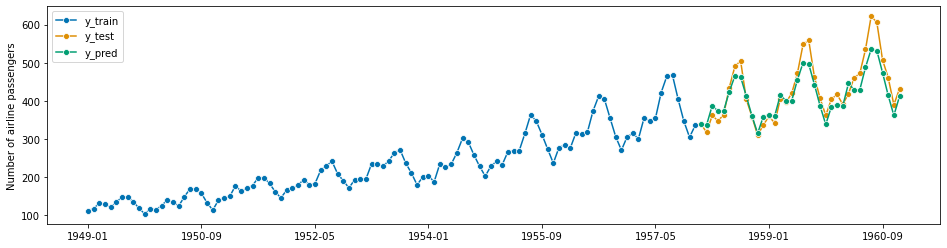

In [54]:
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("forecast", ARIMA()),
    ]
)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

3.2.3 Complex pipeline composites and parameter inspection
sktime follows the scikit-learn philosophy of composability and nested parameter inspection. As long as an estimator has the right scitype, it can be used as part of any composition principle requiring that scitype. Above, we have already seen the example of a forecaster inside a Detrender, which is an estimator of scitype series-to-series-transformer, with one component of forecaster scitype. Similarly, in a TransformedTargetForecaster, we can use the reduction composite from Section 3.1 as the last forecaster element in the pipeline, which inside has an estimator of tabular regressor scitype, the KNeighborsRegressor:

In [58]:
from sklearn.neighbors import KNeighborsRegressor

from sktime.forecasting.compose import make_reduction

C:\Users\trana\.conda\envs\sktime_env\lib\site-packages\sktime\utils\datetime.py:40: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return pd.Int64Index([d.n / count for d in duration])
C:\Users\trana\.conda\envs\sktime_env\lib\site-packages\sktime\forecasting\base\_fh.py:100: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  values = pd.Int64Index(values, dtype=int)
C:\Users\trana\.conda\envs\sktime_env\lib\site-packages\sktime\utils\datetime.py:103: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  assert isinstance(by, (int, np.integer, pd.Int64Index)), type(by)
C:\Users\trana\.conda\envs\sktime_env\lib\site-packages\sktime\utils\datetime.py:40: FutureWarning: pandas.Int

0.06049464828575619

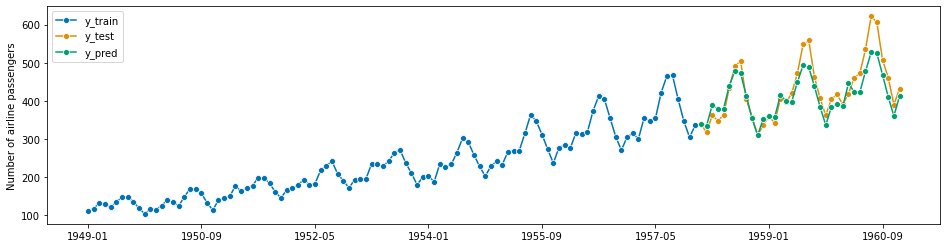

In [59]:
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        (
            "forecast",
            make_reduction(
                KNeighborsRegressor(),
                scitype="tabular-regressor",
                window_length=15,
                strategy="recursive",
            ),
        ),
    ]
)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

3.3 Parameter tuning
sktime provides parameter tuning strategies as compositors of forecaster scitype, similar to scikit-learn's GridSearchCV.



3.3.1 Basic tuning using ForecastingGridSearchCV
The compositor ForecastingGridSearchCV (and other tuners) are constructed with a forecaster to tune, a cross-validation constructor, a scikit-learn parameter grid, and parameters specific to the tuning strategy. Cross-validation constructors follow the scikit-learn interface for re-samplers, and can be slotted in exchangeably. In other words, sktime allows you to perform a parametric study natively.

As an example, we show tuning of the window length in the reduction compositor from Section 3.1, using temporal sliding window tuning:

In [67]:
from sklearn.neighbors import KNeighborsRegressor

from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
)

In [71]:
regressor = KNeighborsRegressor()
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")
param_grid = {"window_length": [5, 6, 7, 12, 15]}

# We fit the forecaster on an initial window which is 80% of the historical data
# then use temporal sliding window cross-validation to find the optimal hyper-parameters
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=20)
gscv = ForecastingGridSearchCV(
    forecaster, strategy="refit", cv=cv, param_grid=param_grid
)

As with other composites, the resulting forecaster provides the unified interface of sktime forecasters - window splitting, tuning, etc requires no manual effort and is done behind the unified interface:

C:\Users\trana\.conda\envs\sktime_env\lib\site-packages\sktime\forecasting\base\_fh.py:96: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return pd.Int64Index([values], dtype=int)
C:\Users\trana\.conda\envs\sktime_env\lib\site-packages\sktime\forecasting\base\_fh.py:100: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  values = pd.Int64Index(values, dtype=int)
C:\Users\trana\.conda\envs\sktime_env\lib\site-packages\sktime\utils\datetime.py:40: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return pd.Int64Index([d.n / count for d in duration])
C:\Users\trana\.conda\envs\sktime_env\lib\site-packages\sktime\utils\datetime.py:103: FutureWarning: pandas.Int64Index is depreca

0.18870411034040024

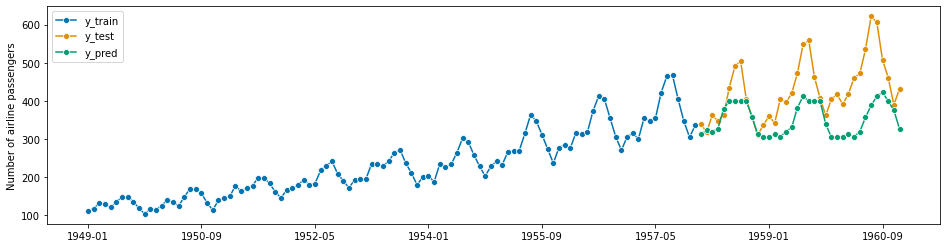

In [72]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

Tuned parameters can be accessed in the best_params_ attribute:


In [73]:
gscv.best_params_


{'window_length': 7}

In [ ]:
An instance of the best forecaster, with hyper-parameters set, can be retrieved by accessing the best_forecaster_ attribute:



In [74]:
gscv.best_forecaster_


RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(),
                                     window_length=7)

3.3.2 Tuning of complex composites
As in scikit-learn, parameters of nested components can be tuned by accessing their get_params key - by default this is [estimatorname]__[parametername] if [estimatorname] is the name of the component, and [parametername] the name of a parameter within the estimator [estimatorname].

For example, below we tune the KNeighborsRegressor component's n_neighbors, in addition to tuning window_length. The tuneable parameters can easily be queried using forecaster.get_params()